In [1]:
import random
import json
import pickle
import nltk
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model
from keras.utils import plot_model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

# Training code steps
1.	Data collection
2.	Prepare Data
3.	Create Training Data
4.	Build the Model
5.	Train the Model
6.	Plot Training Results
7.	Evaluate the Model
8.	Compute Metrics
9.	Visualize Predictions

Download NLTK Resources

In [2]:
nltk.download('omw-1.4')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mo.ghareeb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mo.ghareeb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mo.ghareeb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mo.ghareeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Initialize Variables and Load Data

In [3]:
# Initialize lemmatizer and other variables
lemmatizer = WordNetLemmatizer()
words = []
classes = []
documents = []
ignore_words = ["?", "!", ",", ".", "'s", "'m"]
stop_words = set(nltk.corpus.stopwords.words('english'))
data_file = open("intents.json").read()
intents = json.loads(data_file)

Tokenize and Process Intents

In [4]:
# Tokenize and process intents
for intent in intents["intents"]:
    for pattern in intent["patterns"]:
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent["tag"]))
        if intent["tag"] not in classes:
            classes.append(intent["tag"])

# Lemmatize and clean words
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words and w not in stop_words]
words = sorted(list(set(words)))

# Sort classes
classes = sorted(list(set(classes)))

print(len(documents), "documents")
print(len(classes), "classes", classes)
print(len(words), "unique lemmatized words", words)

# Save words and classes
pickle.dump(words, open("words.pkl", "wb"))
pickle.dump(classes, open("classes.pkl", "wb"))

232 documents
80 classes ['about', 'afternoon', 'anxious', 'ask', 'casual', 'creation', 'death', 'default', 'depressed', 'done', 'evening', 'fact-1', 'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15', 'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-2', 'fact-20', 'fact-21', 'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27', 'fact-28', 'fact-29', 'fact-3', 'fact-30', 'fact-31', 'fact-32', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9', 'friends', 'goodbye', 'greeting', 'happy', 'hate-me', 'hate-you', 'help', 'jokes', 'learn-mental-health', 'learn-more', 'location', 'meditation', 'mental-health-fact', 'morning', 'name', 'neutral-response', 'night', 'no-approach', 'no-response', 'not-talking', 'pandora-useful', 'problem', 'repeat', 'sad', 'scared', 'skill', 'sleep', 'something-else', 'stressed', 'stupid', 'suicide', 'thanks', 'understand', 'user-advice', 'user-agree', 'user-meditation', 'worthless', 'wrong']
248 unique lemmatized words ["'ll", "'re", "'ve

Create Training Data

In [5]:
training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

random.shuffle(training)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print("Training data created")

Training data created


Build the Model

In [6]:
model = Sequential()
model.add(Dense(256, input_shape=(len(train_x[0]),), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation="softmax"))
model.summary()

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               63744     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 80)                10320     
                                                                 
Total params: 106,960
Trainable params: 106,960
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [7]:
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1, validation_split=0.1)

Epoch 1/200
34/34 [==============================] - 1s 13ms/step - loss: 4.3637 - accuracy: 0.0120 - val_loss: 4.3474 - val_accuracy: 0.0000e+00
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 4.2702 - accuracy: 0.1024 - val_loss: 4.2501 - val_accuracy: 0.0526
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 4.1508 - accuracy: 0.0663 - val_loss: 4.2023 - val_accuracy: 0.0526
Epoch 4/200
34/34 [==============================] - 0s 3ms/step - loss: 4.0142 - accuracy: 0.0964 - val_loss: 4.1224 - val_accuracy: 0.0526
Epoch 5/200
34/34 [==============================] - 0s 3ms/step - loss: 3.8294 - accuracy: 0.1084 - val_loss: 4.0992 - val_accuracy: 0.0526
Epoch 6/200
34/34 [==============================] - 0s 5ms/step - loss: 3.7046 - accuracy: 0.0904 - val_loss: 3.9975 - val_accuracy: 0.1579
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 3.4770 - accuracy: 0.1807 - val_loss: 3.9009 - val_accuracy: 0.1053
Epoch 8/

# Plot Training History

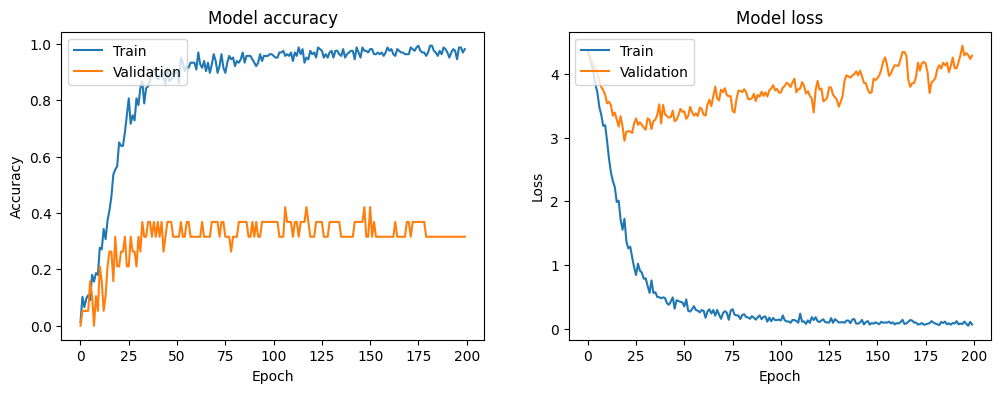

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(hist)

# Save the Model

In [9]:
model.save("Psychologist.h5")
print("Model created and saved")

Model created and saved


# Evaluate the Model

In [10]:
loss, accuracy = model.evaluate(test_x, test_y)
print("Loss of the model is - ", loss)
print("Accuracy of the model is - ", accuracy * 100, "%")

2/2 [==============================] - 0s 6ms/step - loss: 6.0315 - accuracy: 0.4043
Loss of the model is -  6.0315446853637695
Accuracy of the model is -  40.425533056259155 %


# Plot Training and Validation Accuracy and Loss

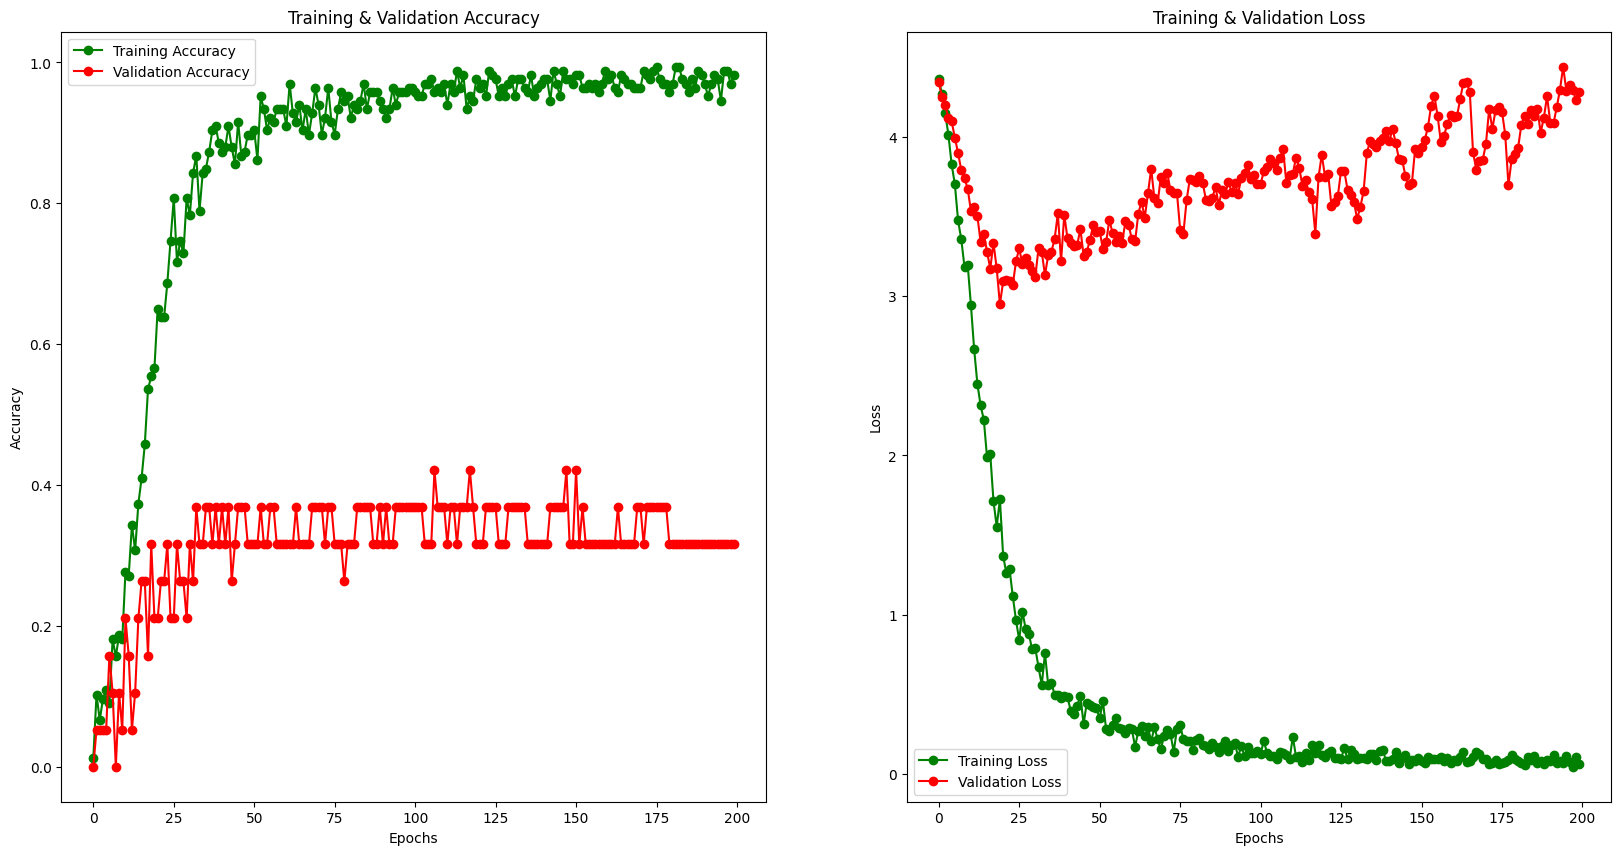

In [11]:
num_epochs = len(hist.history['accuracy']) 

epochs = [i for i in range(num_epochs)]
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

# Generate Predictions and Confusion Matrix

c:\Users\mo.ghareeb\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mo.ghareeb\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mo.ghareeb\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

                    precision    recall  f1-score   support

             about       0.33      0.50      0.40         2
            casual       0.00      0.00      0.00         1
          creation       1.00      1.00      1.00         1
             death       1.00      1.00      1.00         2
         depressed       0.00      0.00      0.00         1
            fact-1       0.00      0.00      0.00         1
           fact-11       0.00      0.00      0.00         1
           fact-12       0.00      0.00      0.00         1
           fact-17       0.00      0.00      0.00         1
           fact-20       0.00      0.00      0.00         1
           fact-22       0.00      0.00      0.00         1
           fact-23       0.00      0.00      0.00         1
           fact-26       0.33      1.00      0.50         1
           fact-27       0.00      0.00      0.00         1
           fact-28       0.00      0.00      0.00         1
           fact-31       0.00      0.00

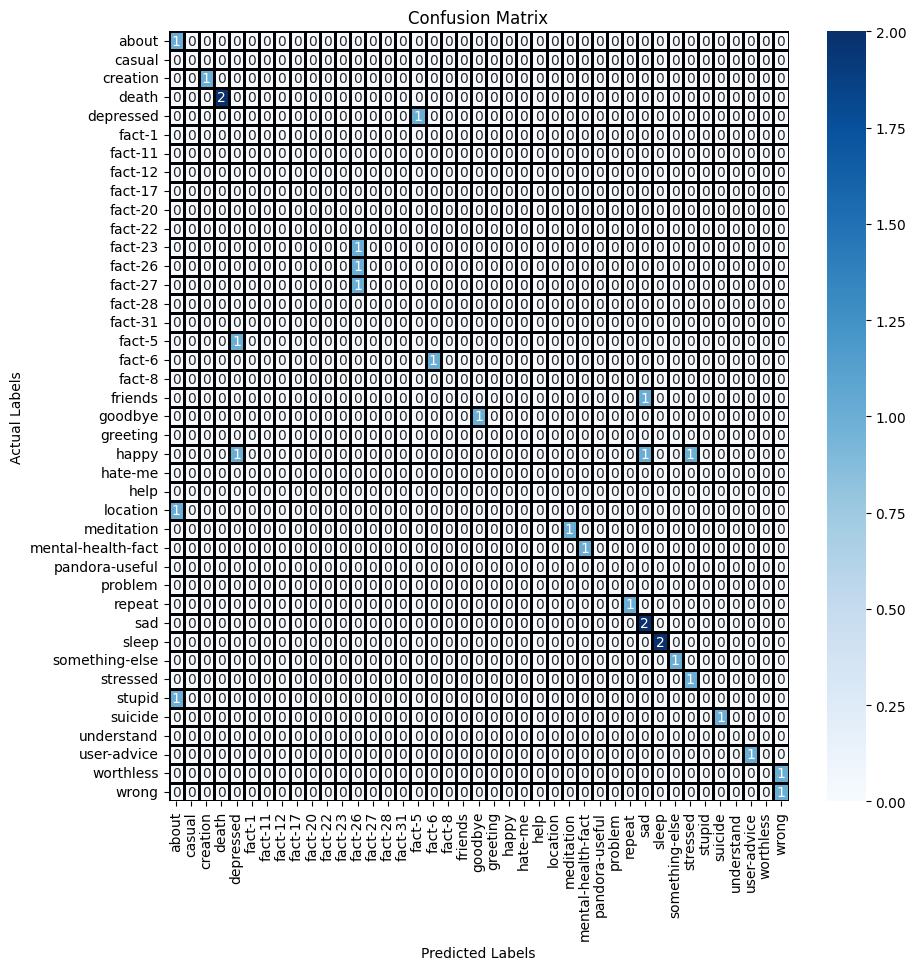

In [14]:
import pandas as pd
unique_labels = np.unique(y_test_labels)
filtered_classes = [classes[i] for i in unique_labels]

print(classification_report(y_test_labels, predictions, target_names=filtered_classes, labels=unique_labels))

cm = confusion_matrix(y_test_labels, predictions, labels=unique_labels)
cm_df = pd.DataFrame(cm, index=filtered_classes, columns=filtered_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()